# Preprocessing
\
The raw data are point clouds generated by MLS (mobile LiDAR). The very first preprocessing step involves processing by the SLAM algorithm (more specifically, via the application provided by GeoSLAM), and unzip files.

Then, the next part consists in classifying ground points, generating a DTM, and extracting vegetation points in a slice parallel to DTM. This step is carried out using the opensource software Computree, and is detailed in the file computree_steps.xsct2 (it is ready to use, only the input files need to be selected and the output folder specified, parameters can also be viewed and modified).

Note: depending on the device you are using, it may be necessary to tile the point cloud before processing with Computree. In this case, make sure you convert to point format 7 and merge the output tile files before moving on. I recommend using CloudCompare for tiling and for converting .laz to .las.

*Output folder: 'computree_outputs'*

# Clustering
\
A shape (branch, trunk, etc.) is characterised by a high point density. To eliminate noise such as foliage, point clouds are clustered using a DBSCAN (density-based spatial clustering of applications with noise) algorithm. Clusters are then filtered in order to eliminate high branches, shapes that are mostly outside the inventory plot (radius 18m), shapes not long enough and remaining noise clusters with a low number of points.

The clustering results are then exported as a point cloud (.las file), and as individual cluster images for classification.

*Input folder: 'computree_outputs'*  
*Output folders: 'clusters_las' (.las files), 'clusters_img' (.png files)*

In [1]:
# Loading packages and modules
import os
import glob
import laspy
from clustering import ClEngine, Cluster

las_files_path = 'computree_outputs' # location of preprocessed files
clusters_las_path = 'clusters_las' # location of clustered .las files
clusters_img_path = 'clusters_img' # location of cluster images

spheres_file = 'preprocessing/spheres_coordinates.csv' # file containing plot centre coordinates

# Cluster image params
figsize = (4,4)
dpi = 75

# Listing all .las files to cluster
las_files = glob.glob('computree_outputs/*.las')

# Listing already clustered files
clustered = glob.glob(clusters_las_path + '/*.las')
clustered_names = [os.path.splitext(os.path.basename(file))[0] for file in clustered]

In [2]:
for file in las_files:
    
    # Checking if the file is not already clustered
    if os.path.splitext(os.path.basename(file))[0]+'_clusters' not in clustered_names:
        
        cl = ClEngine(file)
        
        # Cluster .las file points
        cl.DBSCAN_clustering(eps=0.05, min_samples=100) # distance parameters are in meters
        
        # Filter clusters given on a minimum number of points, distance from the plot centre, distance from the ground,
        # and minimum length. Set argument to None to ignore filter. Note that the filter based on minimum length take
        # a long time to process.
        cl.filtering(nb_points=500,
                      coord_file=spheres_file,
                      sep=';',
                      dec=',',
                      distance_from_centre=18,
                      delta=0.5,
                      min_dist=None)
        
        # Draw a (very) basic representation of the clusters
        # cl.draw_clusters()
        
        # Save clustering results in new .las files
        cl.save_clusters_las(folder=clusters_las_path, suffix="clusters")
        
        # Save clustering results in .png files
        cl.save_clusters_img(folder=clusters_img_path, figsize=figsize, dpi=dpi)

File 07_04_ct.las loaded successfully.
Clustering 07_04_ct.las points...
Estimated number of clusters: 7765
Estimated number of noise points: 3119568
Filtering clusters...
1593 clusters remaining out of 7766.
Saving unfiltered clusters in .las file...
Clustering results successfully saved in clusters_las/07_04_ct_clusters.las.
Saving unfiltered clusters in .png files...
Images successfully saved in clusters_img/07_04_ct.
File BM01_ct.las loaded successfully.
Clustering BM01_ct.las points...
Estimated number of clusters: 10082
Estimated number of noise points: 7176706
Filtering clusters...
2243 clusters remaining out of 10083.
Saving unfiltered clusters in .las file...
Clustering results successfully saved in clusters_las/BM01_ct_clusters.las.
Saving unfiltered clusters in .png files...
Images successfully saved in clusters_img/BM01_ct.
File BM02_ct.las loaded successfully.
Clustering BM02_ct.las points...
Estimated number of clusters: 8365
Estimated number of noise points: 3251947
Filt

## NNCLR model building
\
The aim is not to spend our time manually classifying images, so we will be using a NNCLR model, adapted to a small labelled training set. The NNCLR model used here is based on the example of https://keras.io/examples/vision/nnclr/ (see link for more details).



*Input/output folder: 'NNCLR_data', containing images for training*

```
NNCLR_data
│
├── labelled
│   ├── deadwood
│   │   ├── image1.png
│   │   ├── image2.png
│   │   ├── ...
│   │
│   └── other
│       ├── image1.png
│       ├── image2.png
│       ├── ...
│
└── unlabelled
    └── unlabelled
        ├── image1.png
        ├── image2.png
        ├── ...
```


In [3]:
import os
import tensorflow as tf
import image_classification as imgclf

# device = 'CPU:0' # device used to run tensorflow
model_path = 'NNCLR_data' # path with labelled and unlabelled images for training
save_path = model_path + '/finetuning_model'
batch_size = 32
num_epochs = 50 # max number of epochs, the model will stop automatically when val_p_loss has not increased for 5 epochs
image_size = (300, 300) # in pixels

If GPU memory is insufficient, the CPU can be used (calculations will take longer). Use :

```
with tf.device('CPU:0'):
    ...
```

Model hyperparameters, for information:

```
input_shape = (image_size[0], image_size[1], 3)
AUTOTUNE = tf.data.AUTOTUNE
shuffle_buffer = 5000   
temperature = 0.1
queue_size = 10000
contrastive_augmenter = {
    "brightness": 0.5,
    "name": "contrastive_augmenter",
    "scale": (0.2, 1.0)}
classification_augmenter = {
    "brightness": 0.2,
    "name": "classification_augmenter",
    "scale": (0.5, 1.0)}
width = 128
```


Found 1567 files belonging to 2 classes.
Using 1254 files for training.
Found 1567 files belonging to 2 classes.
Using 313 files for validation.
Found 6003 files belonging to 1 classes.
Building NNCLR model.
Epoch 1/50
78/78 [==============================] - 35s 218ms/step - c_loss: 3.2498 - c_acc: 0.1203 - r_acc: 0.0169 - p_loss: 8.6858 - p_acc: 0.5432 - val_p_loss: 3.7253e-09 - val_p_acc: 0.9722
Epoch 2/50
78/78 [==============================] - 22s 178ms/step - c_loss: 2.4559 - c_acc: 0.2441 - r_acc: 0.0472 - p_loss: 3.2843 - p_acc: 0.9542 - val_p_loss: 8.1956e-08 - val_p_acc: 0.9653
Epoch 3/50
78/78 [==============================] - 23s 180ms/step - c_loss: 2.1833 - c_acc: 0.2973 - r_acc: 0.0553 - p_loss: 5.4836 - p_acc: 0.9543 - val_p_loss: 3.1542 - val_p_acc: 0.9583
Epoch 4/50
78/78 [==============================] - 24s 193ms/step - c_loss: 1.8384 - c_acc: 0.3408 - r_acc: 0.0760 - p_loss: 9.6495 - p_acc: 0.9632 - val_p_loss: 37.8465 - val_p_acc: 0.9236
Epoch 5/50
78/78 [=====

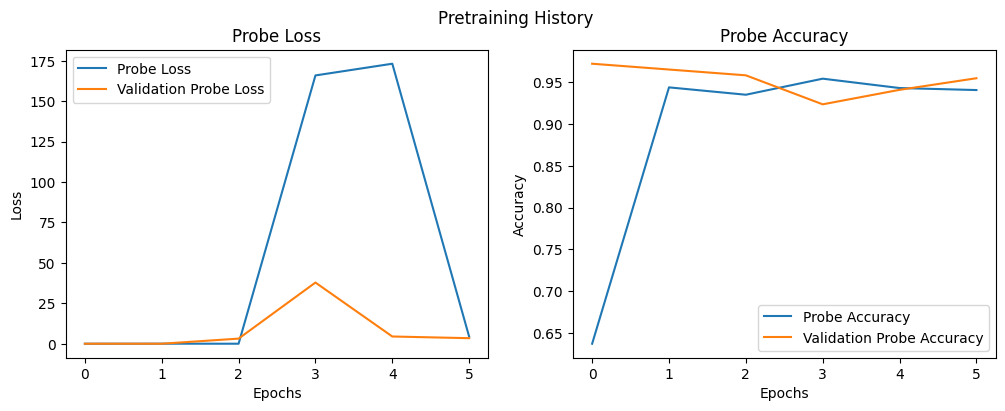

Epoch 1/50
78/78 [==============================] - 8s 66ms/step - loss: 14.3724 - acc: 0.8678 - val_loss: 0.1608 - val_acc: 0.9653
Epoch 2/50
78/78 [==============================] - 6s 63ms/step - loss: 0.1260 - acc: 0.9736 - val_loss: 0.1384 - val_acc: 0.9722
Epoch 3/50
78/78 [==============================] - 6s 62ms/step - loss: 0.1339 - acc: 0.9736 - val_loss: 0.1621 - val_acc: 0.9653
Epoch 4/50
78/78 [==============================] - 6s 57ms/step - loss: 0.1303 - acc: 0.9736 - val_loss: 0.1407 - val_acc: 0.9688
Epoch 5/50
78/78 [==============================] - 6s 60ms/step - loss: 0.1265 - acc: 0.9736 - val_loss: 0.1501 - val_acc: 0.9688
Epoch 6/50
78/78 [==============================] - 6s 59ms/step - loss: 0.1225 - acc: 0.9744 - val_loss: 0.1389 - val_acc: 0.9688
Epoch 7/50
78/78 [==============================] - 6s 60ms/step - loss: 0.1269 - acc: 0.9736 - val_loss: 0.1503 - val_acc: 0.9653


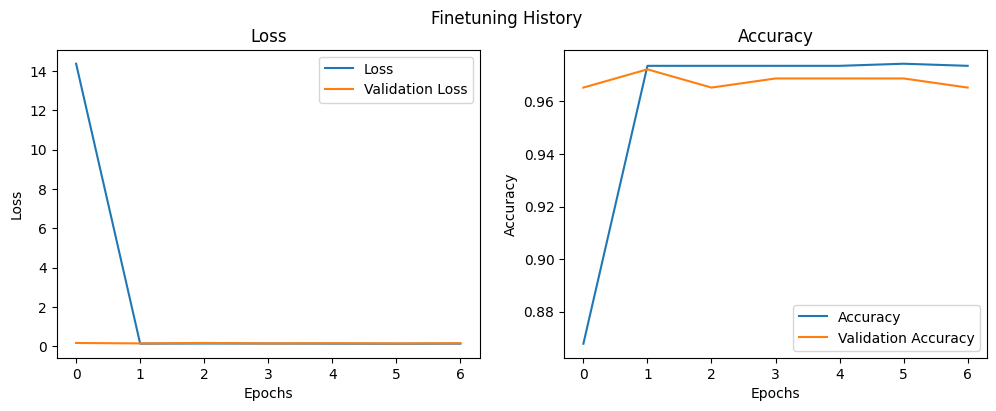

INFO:tensorflow:Assets written to: NNCLR_data/finetuning_model\assets


INFO:tensorflow:Assets written to: NNCLR_data/finetuning_model\assets


In [4]:
# Initialise the model
model = imgclf.Model(model_path, image_size, batch_size, num_epochs)

# Prepare training and validation datasets
model.prepare_dataset()

# Pre-train NNCLR
model.pretraining()
    
# Evaluate the model
model.finetuning(save_path=save_path)

## Image classification
\
*Input folders: 'NNCLR_data', 'clusters_las', 'clusters_img'*  
*Output folder: 'deadwood'*

In [ ]:
import os
import glob
import laspy
import numpy as np
import tensorflow as tf
import image_classification as imgclf
from clustering import ClEngine, Cluster, label_from

# Needed paths
model_path = 'NNCLR_data'
save_path = model_path + '/finetuning_model'
path_las = 'clusters_las'
path_img = 'clusters_img'
path_dw = 'deadwood'

# Same as before
#device = 'CPU:0'
batch_size = 32
num_epochs = 50
image_size = (300, 300)

# Get already classified file names
classified_files = glob.glob(path_dw+'/*.las')
classified_names = [os.path.splitext(os.path.basename(file))[0] for file in classified_files]

In [ ]:
# Re-create model
model = imgclf.Model(model_path, image_size, batch_size, num_epochs)
model.load(save_path)

In [ ]:
# Browse of each study area folder
for folder in glob.glob(path_img+'/*'):
    
    folder_name = os.path.splitext(os.path.basename(folder))[0]
    
    #Check if classification is not already done
    if folder_name + '_deadwood' not in classified_names:
        
        print("Classifying " + folder_name + " images.")
        
        las_file = path_las + '/' + folder_name + '.las'
        
        # Load clusters
        cl = ClEngine(las_file)
        tot = len(cl.get_clusters()) # initial number of clusters
        
        # List of cluster images
        images = glob.glob(folder+'/*.png')
        
        # Make a prediction with the model: each image classified as deadwood by the model, and
        # classified as "other" but with a score < threshold are kept in the final point cloud
        deadwood_images = model.prediction(images, threshold=None)
        
        # List of clusters (cluster labels) classified as deadwood
        deadwood_labels = [label_from(image) for image in deadwood_images]
        
        # Keep clusters classified as deadwood
        cl.keep_clusters(cluster_list=deadwood_labels)
        
        # Save clusters classified as deadwood
        cl.save_clusters_las(path_dw, suffix='deadwood')
        
        print(f"{len(deadwood_labels)} clusters classified as deadwood out of {tot}.)